<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Experimenting_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Packages and Dataset

In [1]:
!pip install timm -q
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Para.7z
!7z x /content/Para.7z

     |████████████████████████████████| 296kB 16.1MB/s 


# Importing Packages

In [3]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import torchvision.transforms.functional as F
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import random_split
import copy
from sklearn.metrics import confusion_matrix,classification_report

device = torch.device('cuda')

In [4]:
data_transforms = {
    'advanced': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        # transforms.
        # transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'basic': transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Dataset Preprocessing

In [45]:
df=pd.read_csv("/content/Dataset/all_meta_data_updated.csv")
df.species=df.species.replace({"Hymenolepis diminuta":"Hymenolepis spp",
                    "Hymenolepis nana":"Hymenolepis spp",
                    "Taenia solium":"na",
                    "Clonorchis sinensis":"na",
                    "Trichinella sp.":"na",
                    "B. coli":"na",
                    "Toxoplasma gondii":"na",
                    })

df['phylum'] = df['phylum'].replace({'Roundworms':'Nematoda','Flatworm':'Platyhelminthes'})
df['class'] = df['class'].replace({'\tConoidasida':'Conoidasida','Tapeworms':'Cestoda'})
df['species'] = df['species'].replace({'Ancyclostoma sp.':'Ancyclostoma sp.','Entamoeba histolytica]':'Entamoeba histolytica'})
df['form'] = df['form'].replace({'rings':'trophozoites','decorticated egg':'egg'})
df['sample'] = df['sample'].replace({'intestinal tissue':'intestine', 'intestine':'intestine'})

df = df[df.species!="na"].reset_index(drop=True)
df.to_csv("/content/all_meta_data_updated.csv",index=False)
def get_train_val(df,val_size=0.25):
    l=np.array(df.index)
    np.random.shuffle(l)
    val_i=int(l.shape[0]*val_size)
    return l[val_i:],l[:val_i]

## Selecting first 19 labels

In [46]:
df = [x for _,x in df.groupby('species') if len(x)>11] # Same species labels as in ensta_colab2.ipynb
df = pd.concat(df)

## Dataset Class

In [27]:
#Defining custom dataset
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,csv_file,idx,transform=None):
        self.meta_data = pd.read_csv(csv_file).iloc[idx,:].reset_index(drop=True)
        # print(self.meta_data.head())
        self.transform = transform
        self.labels=["phylum","class","species","form","sample"]
        self.label_encoder=self.get_label_encode()
        self.nclasses=self.get_nclasses()

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.meta_data.loc[idx,"img_path"]
        image = plt.imread(img_path)
        image = F.to_pil_image(image)
        labels = dict(self.meta_data.loc[idx,self.labels])

        if self.transform:
            image = self.transform(image)
                
        dict_data = {
        'image': image,
        'labels': labels
        }
        return dict_data
    
    def get_label_encode(self):
        d=dict()
        for label in self.labels:            
            le = LabelEncoder()
            self.meta_data[label]=le.fit_transform(self.meta_data[label])
            d[label]=le
        return d
    
    def get_nclasses(self):
        d=dict()
        for label in self.label_encoder:
            d[label]=len(self.label_encoder[label].classes_)
        return d

# NN model

In [28]:
class DNN1(nn.Module):
    def __init__(self,resnet_path,nclasses,labels):
        super(DNN1, self).__init__()
        #number of multi-labels
        self.labels=labels
        #no of out_features forr each label
        self.nclasses=nclasses
        self.nmid_ft=512
        
        #Resnet model
        self.resnet= timm.create_model('resnet50', pretrained=True)
        #input channels of our classifier
        in_features = self.resnet.fc.in_features
        self.dropout=nn.Dropout(0.2)
        
        #Removing the pretrained classifier layer and freezing the weights
        self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        #building our own classifier for each label
        self.fc1=nn.Linear(in_features,self.nmid_ft)
        
        
        self.classifier = nn.ModuleDict()
        for label in labels:
            self.classifier[label]=nn.Linear(self.nmid_ft,nclasses[label])
            
    def forward(self,x):
        """
        for the forward pass of the model, the input image will pass through resnet FCNN
        then it will be flattened and there will be n parallel Dense layer for each label.
        then loss function will be crossentropy which has inbuilt softmax function
        """
        x=torch.relu(self.fc1(self.resnet(x).view(x.shape[0],-1)))
        x=self.dropout(x)
        y=dict()
        for label in self.classifier.keys():
            y[label]=self.classifier[label](x)
        return y

# Data splitting
Choose any of the given cell

In [62]:
from sklearn.model_selection import train_test_split
t,v = train_test_split(df,test_size = 0.25,stratify = df['species'])
train_dataset=Dataset("/content/all_meta_data_updated.csv",idx=t.index, transform=data_transforms["advanced"])

val_dataset=Dataset("/content/all_meta_data_updated.csv",idx=v.index, transform=data_transforms["basic"])

print(train_dataset.nclasses)
print(train_dataset.labels)
print(val_dataset.nclasses)
print(val_dataset.labels)

{'phylum': 5, 'class': 7, 'species': 19, 'form': 10, 'sample': 10}
['phylum', 'class', 'species', 'form', 'sample']
{'phylum': 5, 'class': 7, 'species': 19, 'form': 11, 'sample': 9}
['phylum', 'class', 'species', 'form', 'sample']


In [58]:
trainidx,validx=get_train_val(df,val_size=0.25)
train_dataset=Dataset("/content/all_meta_data_updated.csv",idx=trainidx, transform=data_transforms["advanced"])

val_dataset=Dataset("/content/all_meta_data_updated.csv",idx=validx, transform=data_transforms["basic"])

print(train_dataset.nclasses)
print(train_dataset.labels)
print(val_dataset.nclasses)
print(val_dataset.labels)

{'phylum': 5, 'class': 7, 'species': 19, 'form': 11, 'sample': 10}
['phylum', 'class', 'species', 'form', 'sample']
{'phylum': 5, 'class': 7, 'species': 19, 'form': 10, 'sample': 9}
['phylum', 'class', 'species', 'form', 'sample']


In [48]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True,)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset),shuffle=True,)

# Metrics and training functions

In [49]:
#appending all the loss for each label
def get_loss(out,labels,loss_fn):
    loss=0
    for label in labels:
        loss+=loss_fn(out[label],labels[label])
    return loss/len(labels)


def cal_accuracy(out,labels,batch_size,epoch_acc):
    for key in out:
        q=(out[key].detach().argmax(axis=1)==labels[key]).sum().item()/batch_size
        if not key in epoch_acc.keys():
            epoch_acc[key]=q
        else:
            epoch_acc[key]+=q
    return epoch_acc


def get_avg_acc(epoch_acc,loader):
    acc=0
    for key in epoch_acc:
        epoch_acc[key]/=len(loader)
        acc+=epoch_acc[key]
        
    return acc/len(epoch_acc),epoch_acc

def evaluate(model,loss_fn,loader):
    # print(device)
    model.eval()
    epoch_acc={}
    epoch_loss=0
    for batch in loader:
        img=batch["image"].to(device)
        labels=batch["labels"]
        for key in labels:
            labels[key]=labels[key].to(device)
        
        out=model(img)
        loss=get_loss(out,labels,loss_fn)
        epoch_loss+=loss.detach().item()
        epoch_acc=cal_accuracy(out,labels,img.shape[0],epoch_acc)
        
    avg_acc,epoch_acc=get_avg_acc(epoch_acc,loader)
    return (epoch_loss/len(loader),avg_acc,epoch_acc)


def train_model(model, loss_fn, opt,trainloader,valloader, num_epochs=1):
    since = time.time()
    best_model=""
    max_acc=-999
    train={"loss":[],"avg":[],"individual":[]}
    val={"loss":[],"avg":[],"individual":[]}
    for epoch in range(num_epochs):
        print('Epoch {} of {}'.format(epoch+1, num_epochs))
        epoch_loss=0
        epoch_acc={}
        model.train()
        # Iterate over data.
        for i,data in enumerate(trainloader):
            opt.zero_grad()
            img=data["image"].to(device)
            labels=data["labels"]
            for key in labels:
                labels[key]=labels[key].to(device)
            

            out=model(img)
            loss=get_loss(out,labels,loss_fn)
            epoch_loss+=loss.detach().item()
            loss.backward()
            opt.step()
            epoch_acc=cal_accuracy(out,labels,img.shape[0],epoch_acc)
            
        val_result=evaluate(model,loss_fn,valloader)
        avg_acc,epoch_acc=get_avg_acc(epoch_acc,trainloader)
        avg_loss=epoch_loss/len(trainloader)
        print('Train')
        print(f"Loss: {avg_loss}\nAccuracy: Each_label_acc->{epoch_acc}\n\tAvg acc->{avg_acc}\n")
        print("Validation")
        print(f"Loss: {val_result[0]}\nAccuracy: Each_label_acc->{val_result[2]}\n\tAvg acc->{val_result[1]}")
        print("-"*50)
        
        train["avg"].append(avg_acc)
        train["individual"].append(epoch_acc)
        train["loss"].append(avg_loss)
        
        val["avg"].append(val_result[1])
        val["individual"].append(val_result[2])
        val["loss"].append(val_result[0])
        if val_result[1]>max_acc:
            max_acc=val_result[1]
            best_model=copy.deepcopy(model)

        
       

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return train,val,best_model,max_acc
# train,val=train_model(model, loss_fn, optimizer,trainloader,valloader,num_epochs=2)

# lets train

In [50]:
model=DNN1("drive/My Drive/resnet", train_dataset.nclasses, train_dataset.labels,).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
train,val,best_model,best_acc=train_model(model, loss_fn, optimizer,trainloader,valloader,num_epochs=100)

Epoch 1 of 100
Train
Loss: 1.9675767638466575
Accuracy: Each_label_acc->{'phylum': 0.47321428571428575, 'class': 0.41233766233766234, 'species': 0.08522727272727272, 'form': 0.2719155844155844, 'sample': 0.4492694805194805}
	Avg acc->0.33839285714285716

Validation
Loss: 2.0930068492889404
Accuracy: Each_label_acc->{'phylum': 0.5963302752293578, 'class': 0.47706422018348627, 'species': 0.11009174311926606, 'form': 0.1834862385321101, 'sample': 0.42201834862385323}
	Avg acc->0.3577981651376147
--------------------------------------------------
Epoch 2 of 100
Train
Loss: 1.5562903881072998
Accuracy: Each_label_acc->{'phylum': 0.6943993506493507, 'class': 0.5758928571428572, 'species': 0.25040584415584416, 'form': 0.44358766233766234, 'sample': 0.617288961038961}
	Avg acc->0.5163149350649351

Validation
Loss: 1.9496597051620483
Accuracy: Each_label_acc->{'phylum': 0.5504587155963303, 'class': 0.4954128440366973, 'species': 0.2018348623853211, 'form': 0.27522935779816515, 'sample': 0.57798

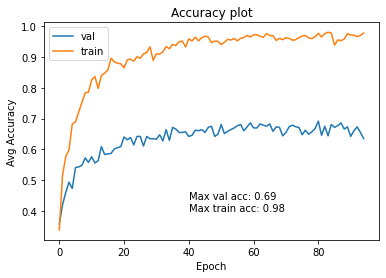

In [53]:
plt.plot(list(range(len(val["avg"][:-5]))),val["avg"][:-5])
plt.plot(list(range(len(train["avg"][:-5]))),train["avg"][:-5])
plt.title("Accuracy plot")
plt.xlabel("Epoch")
plt.ylabel("Avg Accuracy")
plt.legend(["val","train"])
m=max(val["avg"])
t=max(train["avg"])
plt.annotate(f"Max val acc: {m:0.2f}\nMax train acc: {t:0.2f}",(40,0.4))
# plt.annotate(f"Max train acc: {t:0.2f}",(30,0.0))
plt.savefig("Accuracy plot.jpg")

In [68]:
df.species.value_counts()

Plasmodium falciparum        36
Plasmodium vivax             36
Cyclospora cayetanensis      30
Plasmodium malariae          30
Ascaris lumbricoides         29
Plasmodium ovale             27
Giardia duodenalis           27
Entamoeba histolytica        27
Strongyloides stercoralis    22
Dibothriocephalus latus      21
Hymenolepis spp              21
Trichuris Trichuria          19
Enterobius vermicularis      18
Ancyclostoma sp.             17
Toxocara canis               17
Cryptosporidium sp.          16
Sarcocystis sp.              16
Plasmodium knowlesi          15
Echinococcus granulosus      12
Name: species, dtype: int64

# Errors

In [54]:
from collections import Counter

def get_attrs(out,labels):
    o=torch.ones((len(labels),len(labels["phylum"])))
    l=torch.ones((len(labels),len(labels["phylum"])))
    for i,key in enumerate(labels):
        o[i]=out[key].cpu().argmax(axis=1)
        l[i]=labels[key]
        
    return dict(Counter((o==l).sum(axis=0).numpy()))
# Counter(((l==o).sum(axis=0)))


def cal_accuracy(out,labels,batch_size,epoch_acc):
    for key in out:
        q=(out[key].detach().argmax(axis=1)==labels[key]).sum().item()/batch_size
        if not key in epoch_acc.keys():
            epoch_acc[key]=q
        else:
            epoch_acc[key]+=q
    return epoch_acc
    


def get_avg_acc(epoch_acc,loader):
    acc=0
    for key in epoch_acc:
        epoch_acc[key]/=len(loader)
        acc+=epoch_acc[key]
        
    return acc/len(epoch_acc),epoch_acc

def get_report(out,labels):
    c=0
    rep=""
    for key in labels:
        if c==0:
            c+=1
            r=classification_report(labels[key].cpu(),out[key].cpu().argmax(axis=1),target_names=val_dataset.label_encoder[key].classes_,output_dict=True)
            rep=pd.DataFrame(r).transpose()
            rep=rep.append(pd.Series(dtype=str,name=key)).append(pd.Series(dtype=str,name="")).append(pd.Series(dtype=str,name=""))
        else:
            r=classification_report(labels[key].cpu(),out[key].cpu().argmax(axis=1),target_names=val_dataset.label_encoder[key].classes_,output_dict=True)
            r=pd.DataFrame(r).transpose()
            rep=rep.append(r).append(pd.Series(dtype=str,name=key)).append(pd.Series(dtype=str,name="")).append(pd.Series(dtype=str,name=""))
    return rep
# report(out,labe)

def evaluate_test(model,loss_fn,loader):
    # print(device)
    model.eval()
    epoch_acc={}
    # epoch_loss=0

    for batch in loader:
        img=batch["image"].to(device)
        labels=batch["labels"]
        for key in labels:
            labels[key]=labels[key].to(device)
        
        out=model(img)
        epoch_acc=cal_accuracy(out,labels,img.shape[0],epoch_acc)
        report=get_report(out,labels)
        attrbs=get_attrs(out,labels)
        
    avg_acc,epoch_acc=get_avg_acc(epoch_acc,loader)
    return (avg_acc,epoch_acc,attrbs),report

r,report=evaluate_test(best_model,loss_fn=loss_fn,loader=valloader)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

In [ ]:
r

In [ ]:
report